# Malmquist bias

## Identify the effects of cutting in magnitude near 5$\sigma$

In [1]:
import os, sys
import h5py
import numpy as np
import matplotlib.pyplot as plt   #plotting routines
from matplotlib.backends.backend_pdf import PdfPages
from utils import *

%matplotlib inline

In [2]:
test_filename              = 'PhotoZML/data/test_dc2_validation_9816.hdf5'   # relative path
train_filename             = 'PhotoZML/data/test_dc2_training_9816.hdf5' # relative path
testFile_absPath=os.path.realpath(os.path.normpath(os.path.join("./", test_filename)))
trainFile_absPath=os.path.realpath(os.path.normpath(os.path.join("./", train_filename)))

In [3]:
h5_file = load_raw_hdf5_data(testFile_absPath, groupname='photometry')
dataArray = group_entries(h5_file)
print(dataArray.shape)

(20449, 15)


In [4]:
gal_id, u_mag, u_err,\
        g_mag, g_err,\
        r_mag, r_err,\
        i_mag, i_err,\
        z_mag, z_err,\
        y_mag, y_err,\
        context, z = (col.ravel() for col in np.hsplit(dataArray, dataArray.shape[1]))
print(u_mag.shape, u_err.shape, u_mag[0:10])

(20449,) (20449,) [21.86380005 21.16619873 20.19165611 19.16210747 18.99630928 22.60641861
 20.77092171 24.33146858 23.9744854  23.61293983]


In [5]:
filtersPath = os.path.realpath('./LEPHARELSST/filt/lsst_baseline')
print(filtersPath)
filtersList = np.array( [ os.path.join(filtersPath, 'total_u.pb'),\
                           os.path.join(filtersPath, 'total_g.pb'),\
                           os.path.join(filtersPath, 'total_r.pb'),\
                           os.path.join(filtersPath, 'total_i.pb'),\
                           os.path.join(filtersPath, 'total_z.pb'),\
                           os.path.join(filtersPath, 'total_y.pb') ] )
print(filtersList.shape)

/pbs/throng/lsst/users/jocheval/Intern2022_PhotoZ/LEPHARELSST/filt/lsst_baseline
(6,)


In [6]:
class sigma_rand():
    """
    Eq. (3.2) from LSST Science Book
    """
    def __call__(self, m, m5=None, tvis=30, X=1.2, band='u'):
        if band == 'u':
            Cm, msky, theta, km, gamma =\
            23.60, 21.8, 0.77, 0.48, 0.037
        elif band == 'g':
            Cm, msky, theta, km, gamma =\
            24.57, 22.0, 0.73, 0.21, 0.038
        elif band == 'r':
            Cm, msky, theta, km, gamma =\
            24.57, 21.3, 0.70, 0.10, 0.039
        elif band == 'i':
            Cm, msky, theta, km, gamma =\
            24.47, 20.0, 0.67, 0.07, 0.039
        elif band == 'z':
            Cm, msky, theta, km, gamma =\
            24.19, 19.1, 0.65, 0.06, 0.040
        elif band == 'y':
            Cm, msky, theta, km, gamma =\
            23.74, 17.5, 0.63, 0.06, 0.040
            
        if m5 is None:
            m5 = Cm + 0.50*(msky - 21) + 2.5*np.log10(0.7/theta) + 1.25*np.log10(tvis/30) - km*(X - 1)
        
        x = 10 ** (0.4*(m - m5))
        sigRand2 = (0.04 - gamma)*x + gamma * x**2
        return np.sqrt(sigRand2), m5

    def __str__(self):
        return str(self.__dict__)

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

In [7]:
def sigma1(arrayMag, strBand, m5=None, tvis=30, X=1.2, sig_sys=0.003):
    sig_rand = sigma_rand()
    arraySig = np.array([])
    for m in arrayMag:
        sigRand, fiveSigDepth = sig_rand(m, m5=m5, tvis=tvis, X=X, band=strBand)
        arraySig = np.append(arraySig, np.sqrt(sigRand**2 + sig_sys**2))
    print('5-sigma depth is: {}'.format(fiveSigDepth))
    return arraySig

5-sigma depth is: 23.80051828710444


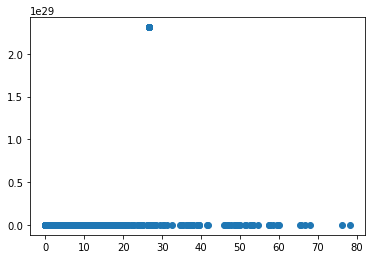

In [8]:
plt.scatter(u_err, sigma1(u_mag, 'u'))

In [9]:
mag, snr = 31.8, 5
# Filter mag entries
indexes=filter_mag_entries(dataArray, mag_filt=mag)
#print(indexes.shape)
data_f0=dataArray
data_f=np.delete(dataArray,indexes,axis=0)
data_f_removed=dataArray[indexes,:]

# Get data better than SNR
indexes_snr=filter_sigtonoise_entries(data_f,nsig=snr)
data_f_removed=np.row_stack((data_f_removed, data_f[indexes_snr,:]))
data_f=np.delete(data_f,indexes_snr,axis=0)
print("Filters: {} original, {} removed, {} left ({} total for check).".format(data_f0.shape,\
                                                                                          data_f_removed.shape,\
                                                                                          data_f.shape,\
                                                                                          data_f_removed.shape[0]+data_f.shape[0]))

Filters: (20449, 15) original, (12897, 15) removed, (7552, 15) left (20449 total for check).


In [10]:
gal_id_clean, u_mag_clean, u_err_clean,\
        g_mag_clean, g_err_clean,\
        r_mag_clean, r_err_clean,\
        i_mag_clean, i_err_clean,\
        z_mag_clean, z_err_clean,\
        y_mag_clean, y_err_clean,\
        context_clean, z_clean = (col.ravel() for col in np.hsplit(data_f, data_f.shape[1]))
print(u_mag_clean.shape, u_err_clean.shape, u_mag_clean[0:10])

(7552,) (7552,) [21.86380005 21.16619873 20.19165611 19.16210747 18.99630928 22.60641861
 20.77092171 24.33146858 23.9744854  23.61293983]


5-sigma depth is: 23.80051828710444


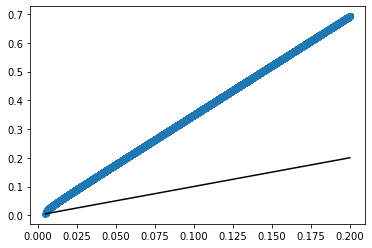

In [11]:
plt.scatter(u_err_clean, sigma1(u_mag_clean, 'u'))
plt.plot([np.min(u_err_clean), np.max(u_err_clean)], [np.min(u_err_clean), np.max(u_err_clean)], c='k')

5-sigma depth is: 25.17


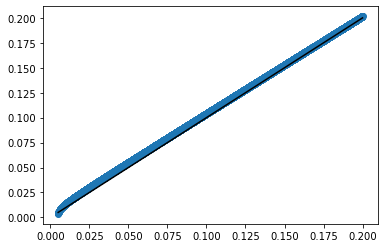

In [12]:
plt.scatter(u_err_clean, sigma1(u_mag_clean, 'u', m5=25.17))
plt.plot([np.min(u_err_clean), np.max(u_err_clean)], [np.min(u_err_clean), np.max(u_err_clean)], c='k')

5-sigma depth is: 24.9824379497345


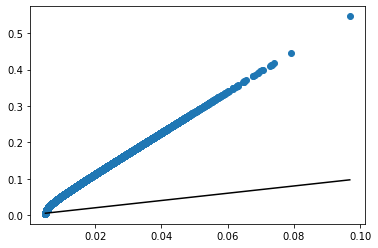

In [13]:
plt.scatter(g_err_clean, sigma1(g_mag_clean, 'g'))
plt.plot([np.min(g_err_clean), np.max(g_err_clean)], [np.min(g_err_clean), np.max(g_err_clean)], c='k')

5-sigma depth is: 26.9


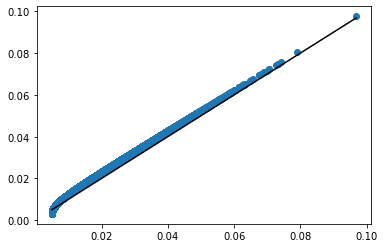

In [14]:
plt.scatter(g_err_clean, sigma1(g_mag_clean, 'g', m5=26.90))
plt.plot([np.min(g_err_clean), np.max(g_err_clean)], [np.min(g_err_clean), np.max(g_err_clean)], c='k')

5-sigma depth is: 24.7


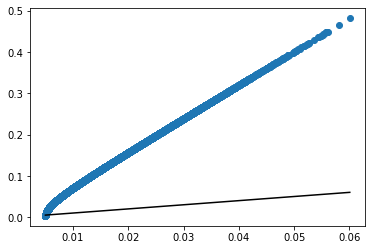

In [15]:
plt.scatter(r_err_clean, sigma1(r_mag_clean, 'r'))
plt.plot([np.min(r_err_clean), np.max(r_err_clean)], [np.min(r_err_clean), np.max(r_err_clean)], c='k')

5-sigma depth is: 27.0


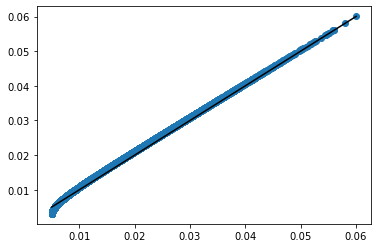

In [16]:
plt.scatter(r_err_clean, sigma1(r_mag_clean, 'r', m5=27.00))
plt.plot([np.min(r_err_clean), np.max(r_err_clean)], [np.min(r_err_clean), np.max(r_err_clean)], c='k')

5-sigma depth is: 24.003558093283576


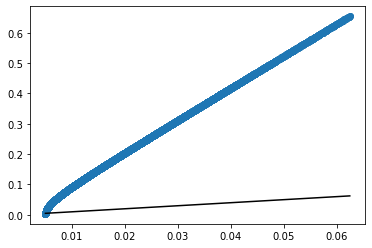

In [17]:
plt.scatter(i_err_clean, sigma1(i_mag_clean, 'i'))
plt.plot([np.min(i_err_clean), np.max(i_err_clean)], [np.min(i_err_clean), np.max(i_err_clean)], c='k')

5-sigma depth is: 26.6


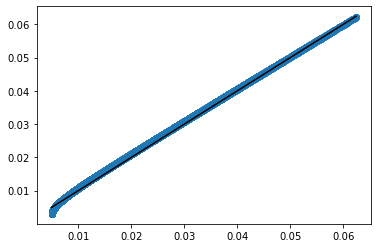

In [18]:
plt.scatter(i_err_clean, sigma1(i_mag_clean, 'i', m5=26.6))
plt.plot([np.min(i_err_clean), np.max(i_err_clean)], [np.min(i_err_clean), np.max(i_err_clean)], c='k')

5-sigma depth is: 23.308461708428503


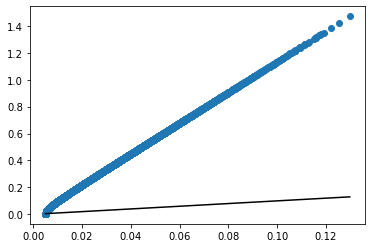

In [19]:
plt.scatter(z_err_clean, sigma1(z_mag_clean, 'z'))
plt.plot([np.min(z_err_clean), np.max(z_err_clean)], [np.min(z_err_clean), np.max(z_err_clean)], c='k')

5-sigma depth is: 25.95


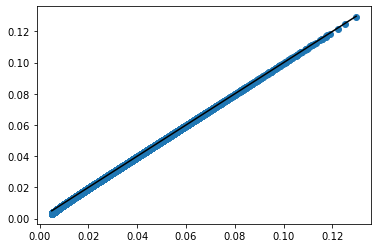

In [20]:
plt.scatter(z_err_clean, sigma1(z_mag_clean, 'z', m5=25.95))
plt.plot([np.min(z_err_clean), np.max(z_err_clean)], [np.min(z_err_clean), np.max(z_err_clean)], c='k')

5-sigma depth is: 22.092393726401685


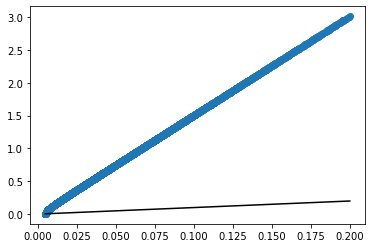

In [21]:
plt.scatter(y_err_clean, sigma1(y_mag_clean, 'y'))
plt.plot([np.min(y_err_clean), np.max(y_err_clean)], [np.min(y_err_clean), np.max(y_err_clean)], c='k')

5-sigma depth is: 25.05


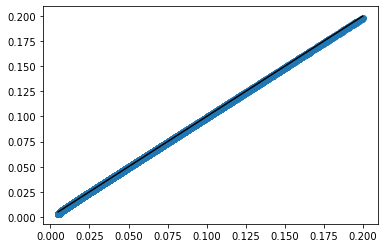

In [22]:
plt.scatter(y_err_clean, sigma1(y_mag_clean, 'y', m5=25.05))
plt.plot([np.min(y_err_clean), np.max(y_err_clean)], [np.min(y_err_clean), np.max(y_err_clean)], c='k')

In [23]:
mag = 50
# Filter mag entries
indexesAbsurd=filter_mag_entries(dataArray, mag_filt=mag)
#print(indexes.shape)
arrayNoAbsurd=np.delete(dataArray,indexesAbsurd,axis=0)

gal_id, u_mag, u_err,\
        g_mag, g_err,\
        r_mag, r_err,\
        i_mag, i_err,\
        z_mag, z_err,\
        y_mag, y_err,\
        context, z = (col.ravel() for col in np.hsplit(arrayNoAbsurd, arrayNoAbsurd.shape[1]))
print(u_mag.shape, u_err.shape, u_mag[0:10])

(18960,) (18960,) [21.86380005 21.16619873 20.19165611 19.16210747 18.99630928 22.60641861
 20.77092171 24.33146858 23.9744854  23.61293983]


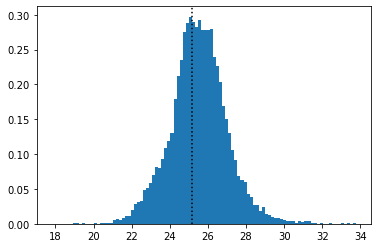

In [24]:
m5u, m5g, m5r, m5i, m5z, m5y = 25.17, 26.90, 27.00, 26.6, 25.95, 25.05
plt.hist(u_mag, bins=100, density=True)
plt.axvline(m5u, c='k', ls=':')

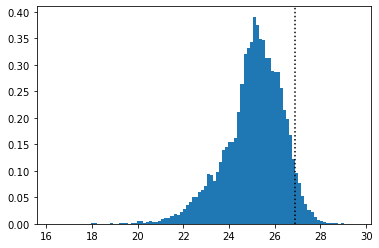

In [25]:
plt.hist(g_mag, bins=100, density=True)
plt.axvline(m5g, c='k', ls=':')

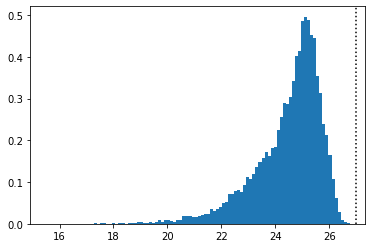

In [26]:
plt.hist(r_mag, bins=100, density=True)
plt.axvline(m5r, c='k', ls=':')

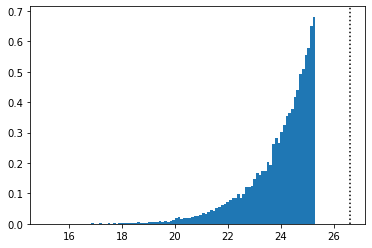

In [27]:
plt.hist(i_mag, bins=100, density=True)
plt.axvline(m5i, c='k', ls=':')

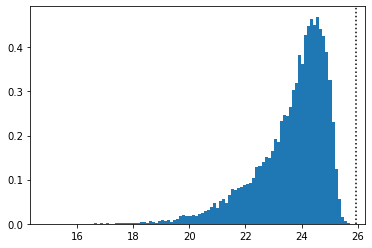

In [28]:
plt.hist(z_mag, bins=100, density=True)
plt.axvline(m5z, c='k', ls=':')

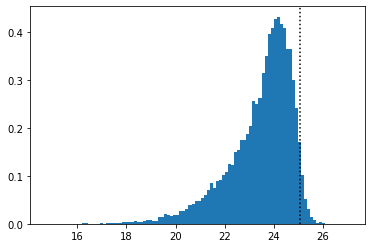

In [29]:
plt.hist(y_mag, bins=100, density=True)
plt.axvline(m5y, c='k', ls=':')

In [30]:
def generate_magnitudes(N, k=0.6, m_min=20, m_max=25): ## from https://www.astroml.org/book_figures/chapter5/fig_lutz_kelker.html
    """
    generate magnitudes from a distribution with
      p(m) ~ 10^(k m) = exp(k*m*ln(10))
    """
    klog10 = k * np.log(10)
    Pmin = np.exp(klog10 * m_min)
    Pmax = np.exp(klog10 * m_max)
    return (1. / klog10) * np.log(Pmin + (Pmax - Pmin) * np.random.random(N))

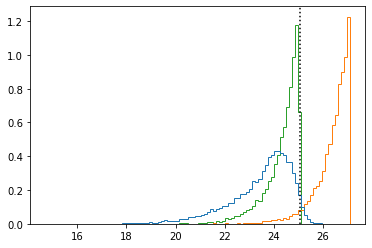

In [31]:
N=10000
ymag_prob=generate_magnitudes(N, m_min=np.min(y_mag), m_max=np.max(y_mag))
ymag_cut=generate_magnitudes(N, m_min=np.min(y_mag), m_max=m5y)
plt.hist((y_mag, ymag_prob, ymag_cut), bins=100, density=True, histtype='step', cumulative=False)
plt.axvline(m5y, c='k', ls=':')

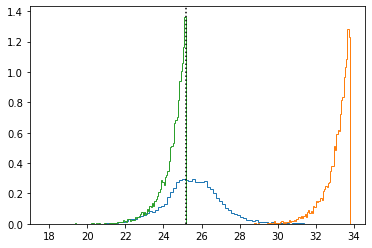

In [32]:
N=10000
umag_prob=generate_magnitudes(N, m_min=np.min(u_mag), m_max=np.max(u_mag))
umag_cut=generate_magnitudes(N, m_min=np.min(u_mag), m_max=m5u)
plt.hist(u_mag, bins=100, density=True, histtype='step', cumulative=False)
plt.hist(umag_prob, bins=100, density=True, histtype='step', cumulative=False)
plt.hist(umag_cut, bins=100, density=True, histtype='step', cumulative=False)
plt.axvline(m5u, c='k', ls=':')

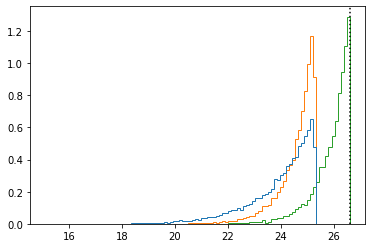

In [33]:
N=10000
imag_prob=generate_magnitudes(N, m_min=np.min(i_mag), m_max=np.max(i_mag))
imag_cut=generate_magnitudes(N, m_min=np.min(i_mag), m_max=m5i)
plt.hist((i_mag, imag_prob, imag_cut), bins=100, density=True, histtype='step', cumulative=False)
plt.axvline(m5i, c='k', ls=':')